## Lecture 1 - 10th April 2024

This notebook presentation is part of my lecture material for the QUARMEN master (QUAntum Research Master Education Network): a two-year international master’s programme in physics, specialized in Quantum Science and Technology. It aims at training students in key concepts and technologies for quantum devices and information. 

This lecture contains a general introduction to parameterized quantum circuits, calculation of gradients and the Pennylane software platform.

**Michele Grossi**, Coordinator of Quantum Computing and Algorithm Competence Center @ CERN \
Last updated: 03 apr 24

## Introduction to Qiskit

Qiskit is a Python-based, open source software development toolkit (SDK) for working with quantum computers.  It can be used at the level of circuits, algorithms, and application modules.

### Installing Qiskit 1.0.X

Anaconda or a pyenv is recommended to manage all dependencies.
The file environment.yml contains the required libraries and can be installed in this way:

*Command:* `conda env create -f environment.yml`


## 1. Create Bell state

A *Bell state*, also known as an *EPR pair* (Einstein-Podolsky-Rosen pair), is a specific two-qubit state which is maximally entangled. Entanglement is another important phenomenon, which characterizes a quantum system, where the quantum states of two or more particles become correlated in such a way that the state of one particle cannot be described independently of the other, regardless of the distance between them.

On the quantum circuit, Bell state can be created by applying a set of quantum states to the initial state $|00\rangle$ :

$$
\begin{align}
& \text{Initial State} = |00\rangle \nonumber \\ \to & H_0|00\rangle  = \frac{1}{\sqrt{2}} (|00\rangle + |10\rangle) \nonumber \\
\to & CNOT_{01}  \frac{1}{\sqrt{2}} (|00\rangle + |10\rangle) = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
\end{align}$$  

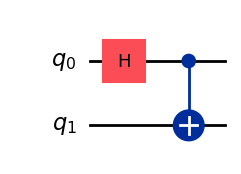

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

You can use local testing mode with simulators from` Qiskit Aer`, which provides higher-performance simulation that can handle larger circuits and custom noise models. It also supports `Clifford` simulation mode, which can efficiently simulate Clifford circuits with a large number of qubits.

In [2]:
from qiskit_aer import AerSimulator
# Print all the available quantum simulators
simulator = AerSimulator()

In [3]:
simulator.available_methods()

('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop')

In [4]:
from qiskit.compiler import transpile
qc.save_statevector()
transp_qc = transpile(qc, simulator)

# Run and get statevector
result = simulator.run(transp_qc).result()

In [5]:
state = result.get_statevector(transp_qc)
print(state)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


#### Visualization of the state
Multi-qubit states can be visualized with the methods other than the bloch sphere.  
- `plot_state_city` : Displays the quantum states as the real and imaginary parts of the state matrix.
- `plot_state_hinton` : Sampe as `plot_state_city`, but as a 2D colour plot.
- `plot_state_qsphere` : Display the quantum state as a vector on a spherical ball. The thickness of the arrow corresponds to the amplitude of the state, and its color to the phase.

In [6]:
from qiskit.visualization import plot_state_city, plot_state_hinton, plot_state_qsphere, \
                                 plot_histogram

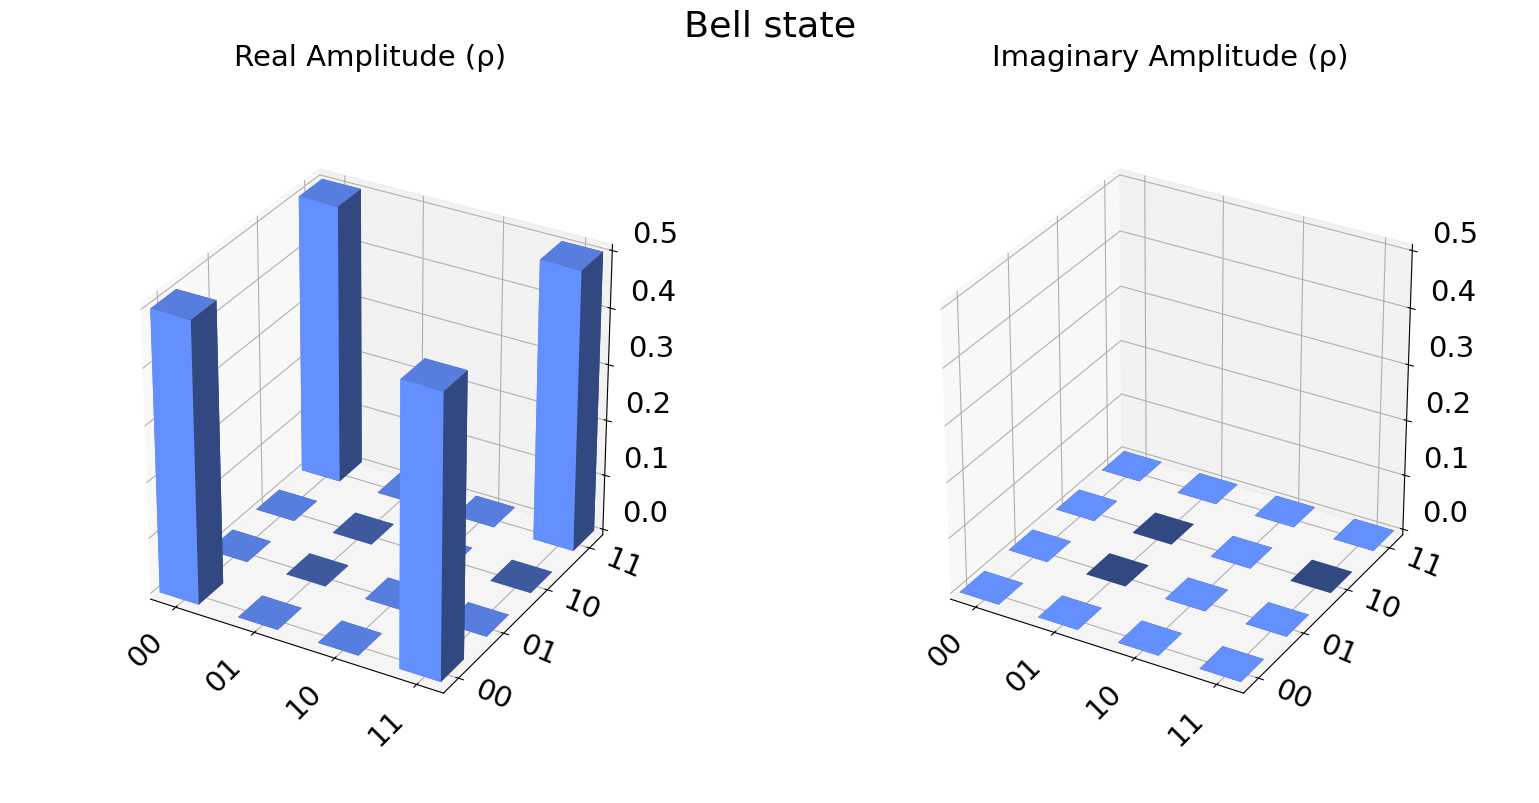

In [7]:
plot_state_city(state, title='Bell state')

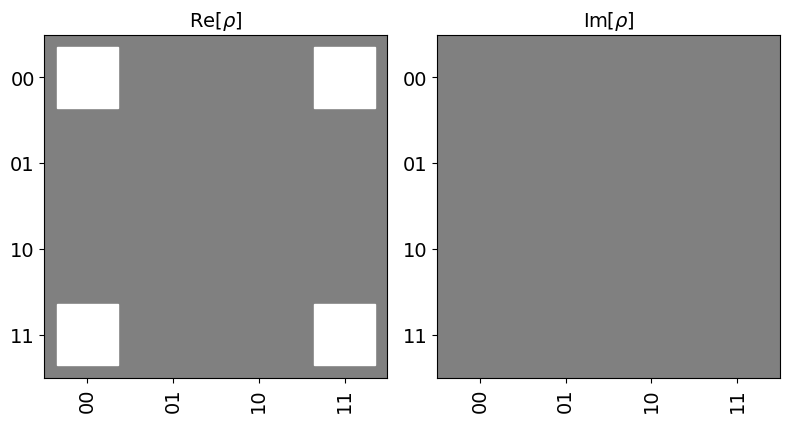

In [8]:
plot_state_hinton(state)

In [9]:
#seaborn package required
#plot_state_qsphere(state2)

#### Simulate with Unitary simulator

In [10]:
# Construct quantum circuit without measure
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.save_unitary()

# Run the quantum circuit on a unitary simulator backend
backend = AerSimulator(method = 'unitary')

# Create job and execute
job2 = backend.run(bell)
result2 = job2.result()

# Show the results
print(result2.get_unitary(bell, decimals=3))


Operator([[ 0.707+0.j,  0.707-0.j,  0.   +0.j,  0.   +0.j],
          [ 0.   +0.j,  0.   +0.j,  0.707+0.j, -0.707+0.j],
          [ 0.   +0.j,  0.   +0.j,  0.707+0.j,  0.707-0.j],
          [ 0.707+0.j, -0.707+0.j,  0.   +0.j,  0.   +0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


#### Simulate with Qasm simulator

Until now on, we simulated the quantum circuit. However in reality, we do not have direct access to the quantum state. Instead, each qubit should be *measured* at the end of the quantum circuit in specific basis (generally in the computational basis $|0\rangle, |1\rangle$). As soon as the quantum system is measured, the state $|\psi\rangle$ *collapses* to the measurement basis $|b\rangle$ with a probability :
$$
P(b) == |\langle b | \psi \rangle |^2.
$$
Unlike the previous steps, we need to add `ClassicalRegister` to measure the quantum circuit.
All customization here: https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html

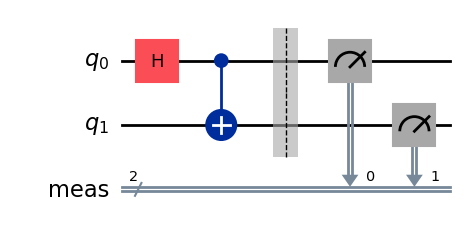

In [11]:
# Construct quantum circuit without measure
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
# Measure qubits
bell.measure_all()

bell.draw(output = 'mpl')

# ALL methods together
Simulation Method Option
The simulation method is set using the method kwarg. A list supported simulation methods can be returned using available_methods(), these are

1- `automatic`: Default simulation method. Select the simulation method automatically based on the circuit and noise model.

2 - `statevector`: A dense statevector simulation that can sample measurement outcomes from ideal circuits with all measurements at end of the circuit. For noisy simulations each shot samples a randomly sampled noisy circuit from the noise model.

3 - `density_matrix`: A dense density matrix simulation that may sample measurement outcomes from noisy circuits with all measurements at end of the circuit.

4 - `stabilizer`: An efficient Clifford stabilizer state simulator that can simulate noisy Clifford circuits if all errors in the noise model are also Clifford errors.

5 - `extended_stabilizer`: An approximate simulated for Clifford + T circuits based on a state decomposition into ranked-stabilizer state. The number of terms grows with the number of non-Clifford (T) gates.

6 - `matrix_product_state`: A tensor-network statevector simulator that uses a Matrix Product State (MPS) representation for the state. This can be done either with or without truncation of the MPS bond dimensions depending on the simulator options. The default behaviour is no truncation.

7 - `unitary`: A dense unitary matrix simulation of an ideal circuit. This simulates the unitary matrix of the circuit itself rather than the evolution of an initial quantum state. This method can only simulate gates, it does not support measurement, reset, or noise.

8 - `superop`: A dense superoperator matrix simulation of an ideal or noisy circuit. This simulates the superoperator matrix of the circuit itself rather than the evolution of an initial quantum state. This method can simulate ideal and noisy gates, and reset, but does not support measurement.

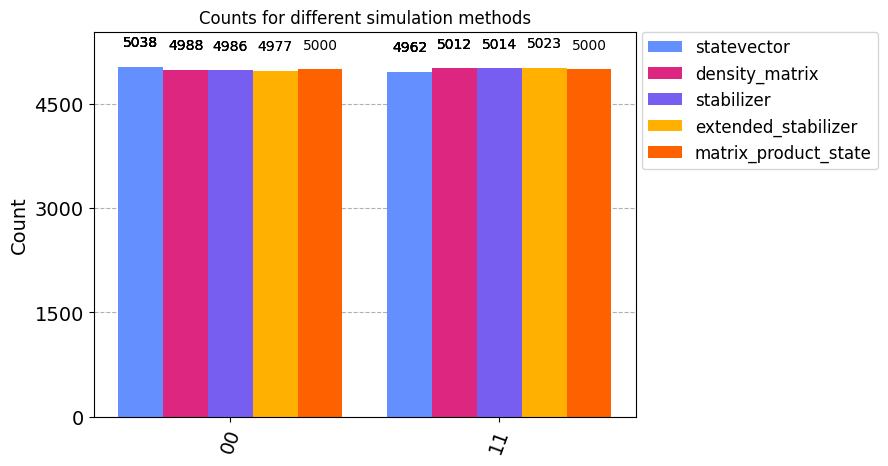

In [12]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()


# Increase shots to reduce sampling variance
shots = 10000



# Statevector simulation method
sim_statevector = AerSimulator(method='statevector')
job_statevector = sim_statevector.run(circ, shots=shots)
counts_statevector = job_statevector.result().get_counts(0)

# Stabilizer simulation method
sim_stabilizer = AerSimulator(method='stabilizer')
job_stabilizer = sim_stabilizer.run(circ, shots=shots)
counts_stabilizer = job_stabilizer.result().get_counts(0)


# Extended Stabilizer method
sim_extstabilizer = AerSimulator(method='extended_stabilizer')
job_extstabilizer = sim_extstabilizer.run(circ, shots=shots)
counts_extstabilizer = job_extstabilizer.result().get_counts(0)

# Density Matrix simulation method
sim_density = AerSimulator(method='density_matrix')
job_density = sim_density.run(circ, shots=shots)
counts_density = job_density.result().get_counts(0)

# Matrix Product State simulation method
sim_mps = AerSimulator(method='matrix_product_state')
job_mps = sim_mps.run(circ, shots=shots)
counts_mps = job_mps.result().get_counts(0)


plot_histogram([ counts_statevector,counts_stabilizer ,counts_extstabilizer, counts_density, counts_mps],
               title='Counts for different simulation methods',
               legend=[ 'statevector',
                       'density_matrix','stabilizer','extended_stabilizer', 'matrix_product_state'])

### Extra: some additional functions

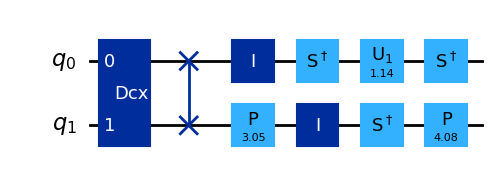

In [13]:
#Import the random circuit class
from qiskit.circuit.random import random_circuit
#Create two random circuits, each with 2 qubit registers and random #gate operator counts.
qc1 = random_circuit(2,2)
qc2 = random_circuit(2,4)
#Concatenate the two random circuits
qc = qc1.compose(qc2)
#Draw the circuit
qc.draw('mpl')

In [14]:
#Define function to print circuit properties:
def print_circuit_props(qc):
    width = qc.width()
    depth = qc.depth()
    num_operators = qc.count_ops()
    circuit_size = qc.size()
    print('Width = ',width) 
    print('Depth = ', depth)
    print('Circuit size = ',circuit_size)
    print('Number of operators = ', num_operators)

In [15]:
#Pass our quantum circuit to print out the circuit properties
print_circuit_props(qc)

Width =  2
Depth =  6
Circuit size =  10
Number of operators =  OrderedDict([('sdg', 3), ('id', 2), ('p', 2), ('dcx', 1), ('swap', 1), ('u1', 1)])


Width =  3
Depth =  1
Circuit size =  1
Number of operators =  OrderedDict([('ccx', 1)])


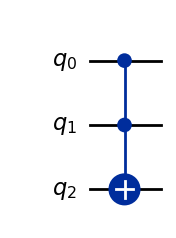

In [16]:
qc = QuantumCircuit(3)
qc.ccx(0,1,2)
#Print out the circuit properties
print_circuit_props(qc)
qc.draw('mpl')

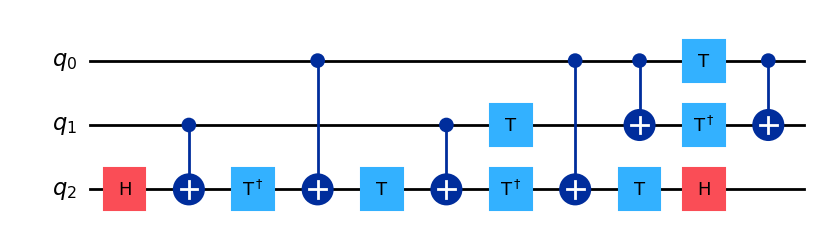

In [17]:
qc.decompose().draw('mpl')

In [18]:
#Print out the circuit properties
print_circuit_props(qc.decompose())

Width =  3
Depth =  11
Circuit size =  15
Number of operators =  OrderedDict([('cx', 6), ('t', 4), ('tdg', 3), ('h', 2)])


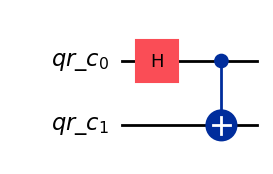

In [19]:
from qiskit import QuantumRegister
#Create a custom two-qubit composite gate
#Create the quantum register
qr = QuantumRegister(2, name='qr_c')
#Generate quantum circuit which will make up the composite gate
comp_qc = QuantumCircuit(qr, name='my-composite')
#Add any gates you wish to your composite gate
comp_qc.h(0)
comp_qc.cx(0, 1)
#Create the composite instructions by converting 
#the QuantumCircuit to a list of Instructions
composite_inst = comp_qc.to_instruction()
#Draw the circuit which will represent the composite gate
comp_qc.draw('mpl')

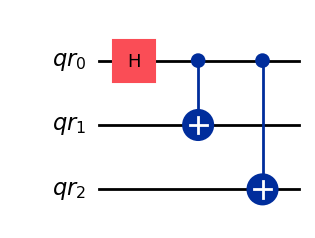

In [20]:
#Create another 3-qubit circuit 
qr2 = QuantumRegister(3, 'qr')
#Create a quantum circuit using the quantum register
qc = QuantumCircuit(qr2)
#Add any arbitrary gates that would represent the function 
#of the composite gate 
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
#Draw the composite circuit
qc.draw('mpl')

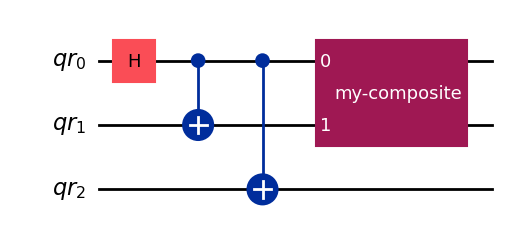

In [21]:
#Append your composite gate to the specified qubits. 
qc.append(composite_inst, [qr2[0], qr2[1]])
#Draw the complete circuit
qc.draw('mpl')

## Parameterized circuits

In [22]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)


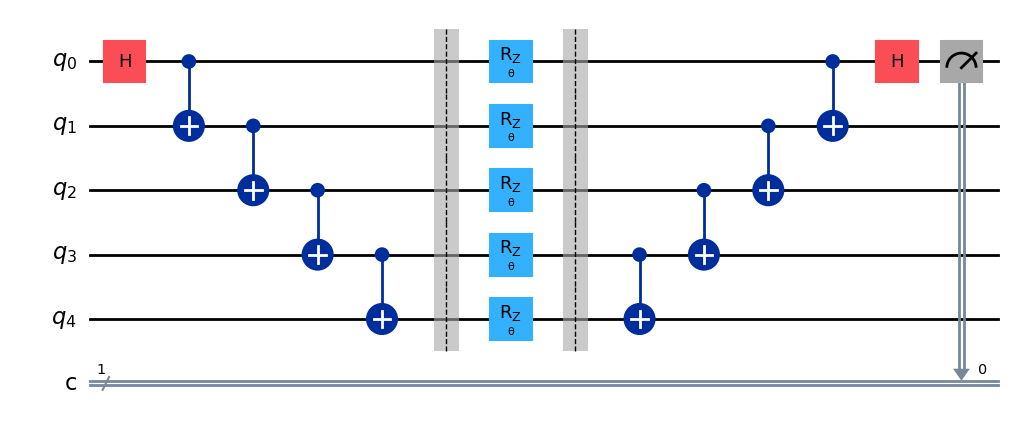

In [23]:
qc.draw('mpl')

### Binding parameters to values
All circuit parameters must be bound before sending the circuit to a backend. This can be done as follows:
- The `assign_parameters` method accepts a dictionary mapping `Parameter`s to values, and returns a new circuit with each parameter replaced by its corresponding value. Partial binding is supported, in which case the returned circuit will be parameterized by any `Parameter`s that were not mapped to a value.
- See https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.ParameterExpression
  

In [24]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.assign_parameters({theta: theta_val})
            for theta_val in theta_range]

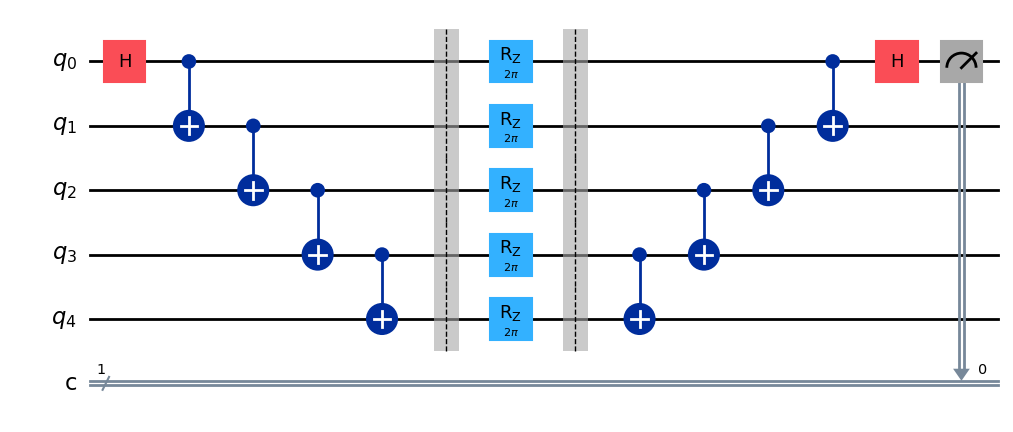

In [25]:
circuits[-1].draw('mpl')

In [26]:
simulator = AerSimulator(method='automatic')
job = simulator.run(circuits, shots=shots)
counts_simulator = job.result().get_counts()

In the example circuit, we apply a global $R_z(\theta)$ rotation on a five-qubit entangled state, and so expect to see oscillation in qubit-0 at $5\theta$.

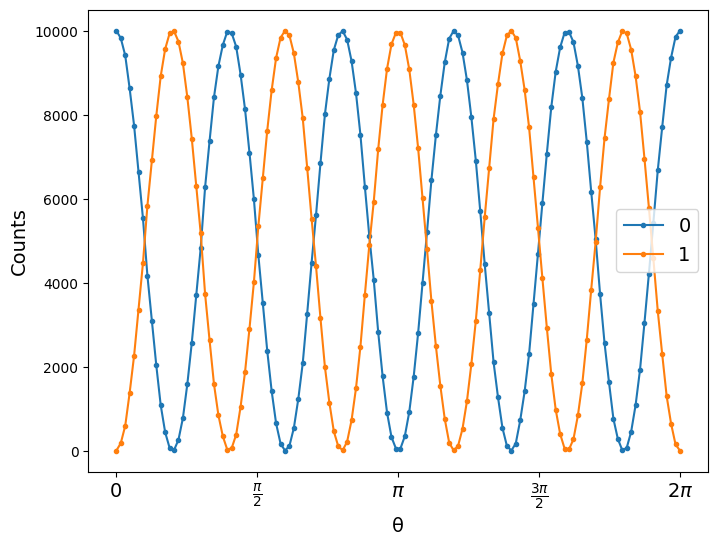

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts_simulator)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts_simulator)), '.-', label='1') 

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

NB To insert a subcircuit under a different parameterization, the `to_instruction` method accepts an optional argument (`parameter_map`) which, when present, will generate instructions with the source parameter replaced by a new parameter.

In [28]:
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])

In [29]:
print(larger_qc.draw())

      ┌────────────────┐
q4_0: ┤0               ├
      │                │
q4_1: ┤1 oracle(theta) ├
      │                │
q4_2: ┤2               ├
      └┬──────────────┬┘
q4_3: ─┤0             ├─
       │              │ 
q4_4: ─┤1 oracle(phi) ├─
       │              │ 
q4_5: ─┤2             ├─
      ┌┴──────────────┴┐
q4_6: ┤0               ├
      │                │
q4_7: ┤1 oracle(gamma) ├
      │                │
q4_8: ┤2               ├
      └────────────────┘


In [30]:
print(larger_qc.decompose().draw())

      ┌───────────┐                                    
q4_0: ┤ Rz(theta) ├──■─────────────────────────────────
      └───────────┘┌─┴─┐┌───────────┐                  
q4_1: ─────────────┤ X ├┤ Rz(theta) ├──■───────────────
                   └───┘└───────────┘┌─┴─┐┌───────────┐
q4_2: ───────────────────────────────┤ X ├┤ Rz(theta) ├
       ┌─────────┐                   └───┘└───────────┘
q4_3: ─┤ Rz(phi) ├───■─────────────────────────────────
       └─────────┘ ┌─┴─┐ ┌─────────┐                   
q4_4: ─────────────┤ X ├─┤ Rz(phi) ├───■───────────────
                   └───┘ └─────────┘ ┌─┴─┐ ┌─────────┐ 
q4_5: ───────────────────────────────┤ X ├─┤ Rz(phi) ├─
      ┌───────────┐                  └───┘ └─────────┘ 
q4_6: ┤ Rz(gamma) ├──■─────────────────────────────────
      └───────────┘┌─┴─┐┌───────────┐                  
q4_7: ─────────────┤ X ├┤ Rz(gamma) ├──■───────────────
                   └───┘└───────────┘┌─┴─┐┌───────────┐
q4_8: ───────────────────────────────┤ X ├┤ Rz(g

### Extra about visualization

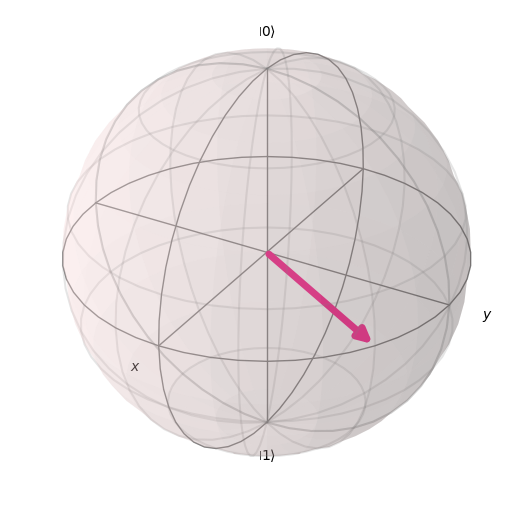

In [31]:
import numpy as np
from qiskit.visualization import plot_bloch_vector
 
# You can use spherical coordinates instead of cartesian.
plot_bloch_vector([1, np.pi/2, np.pi/3], coord_type='spherical')



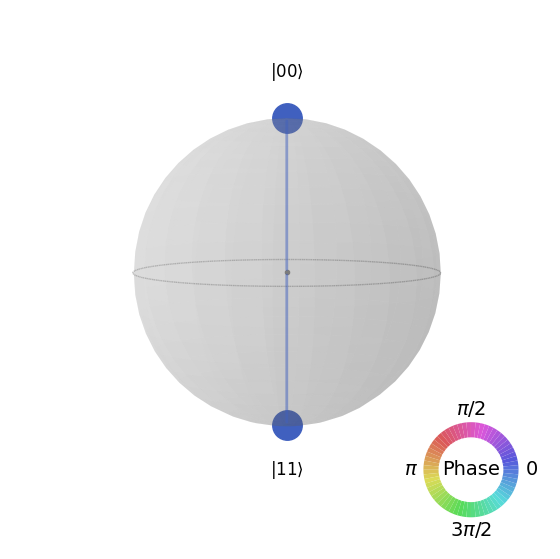

In [32]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere
 

plot_state_qsphere(state)

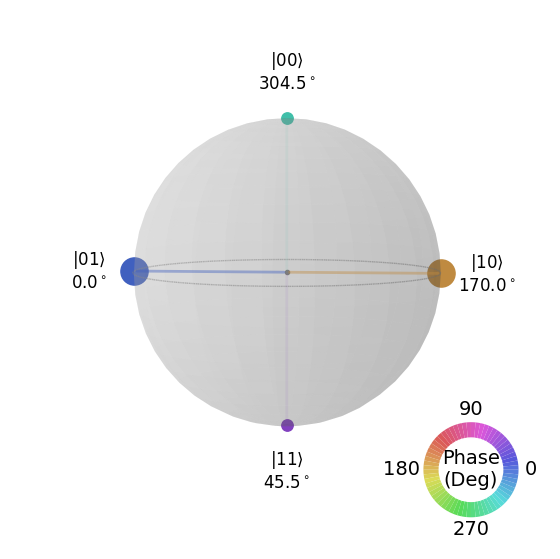

In [33]:
# You can show the phase of each state and use
# degrees instead of radians
 
from qiskit.quantum_info import DensityMatrix
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_qsphere
 
qc = QuantumCircuit(2)
qc.h([0, 1])
qc.cz(0,1)
qc.ry(np.pi/3, 0)
qc.rx(np.pi/5, 1)
qc.z(1)
 
matrix = DensityMatrix(qc)
plot_state_qsphere(matrix,show_state_phases = True, use_degrees = True)

# Introduction to providers

## Runtime local testing mode

Local testing mode (available with `qiskit-ibm-runtime` 0.22.0 or later) can be used to help develop and test programs before fine-tuning them and sending them to real quantum hardware.  After using local testing mode to verify your program, all you need to change is the backend name to run it on an IBM Quantum system.

To use local testing mode, specify one of the fake backends from `qiskit_ibm_runtime.fake_provider` or specify a Qiskit Aer backend when instantiating a primitive or a session.

*   **Fake backends**: The [fake backends](/api/qiskit-ibm-runtime/fake_provider)  in `qiskit_ibm_runtime.fake_provider` mimic the behaviors of IBM Quantum™ systems by using system snapshots. The system snapshots contain important information about the quantum system, such as the coupling map, basis gates, and qubit properties, which are useful for testing the transpiler and performing noisy simulations of the system. The noise model from the snapshot is automatically applied during simulation.

*   **Aer simulator**: Simulators from [Qiskit Aer](simulate-with-qiskit-aer) provide higher-performance simulation that can handle larger circuits and [custom noise models](building_noise_models). It also supports Clifford simulation mode, which can efficiently simulate Clifford circuits with a large number of qubits.

`If you currently use the Qiskit SDK, you can use the existing Qiskit Aer primitives for local testing.  See [exact and noisy simulation with Qiskit Aer primitives](../verify/simulate-with-qiskit-aer) for details.`


## Fake backends example

In [34]:
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# Run the sampler job locally using FakeManilaV2
fake_manila = FakeManilaV2()
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
isa_qc = pm.run(qc)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}
sampler = Sampler(backend=fake_manila, options=options)

result = sampler.run([isa_qc]).result()

## AerSimulator examples

Example with sessions, without noise:

In [35]:
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

# Run the sampler job locally using AerSimulator.
# Session syntax is supported but ignored because local mode doesn't support sessions.
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
with Session(backend=aer_sim) as session:
    sampler = Sampler(session=session)
    result = sampler.run([isa_qc]).result()

/opt/homebrew/Caskroom/miniforge/base/envs/quarmen2/lib/python3.9/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


### Clifford simulation

Because Clifford circuits can be simulated efficiently with verifiable results, Clifford simulation is a very useful tool. For an in-depth example, see [Efficient simulation of stabilizer circuits with Qiskit Aer primitives](stabilizer-circuit-simulation).

Example:

In [36]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import SamplerV2 as Sampler

n_qubits = 500  # <---- note this uses 500 qubits!
circuit = EfficientSU2(n_qubits)
circuit.measure_all()

rng = np.random.default_rng(1234)
params = rng.choice(
    [0, np.pi / 2, np.pi, 3 * np.pi / 2],
    size=circuit.num_parameters,
)

# Tell Aer to use the stabilizer (clifford) simulation method
aer_sim = AerSimulator(method="stabilizer")

pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(backend=aer_sim)
result = sampler.run([isa_qc]).result()

## Noisy Simulation
Here we show how to use the Qiskit Aer [`noise`](https://qiskit.org/ecosystem/aer/apidocs/aer_noise.html) module to build noise models for simulating quantum circuits in the presence of errors. This is useful for emulating noisy quantum processors and for studying the effects of noise on the execution of quantum algorithms.

In [37]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

## Qiskit Aer `noise` module

The Qiskit Aer `noise` module contains Python classes to build customized noise models for simulation. There are three key classes:

1.  The `NoiseModel` class which stores a noise model used for noisy simulation.

2.  The `QuantumError` class which describes CPTP gate errors. These can be applied:

    *   After *gate* or *reset* instructions

    *   Before *measure* instructions.

3.  The `ReadoutError` class which describes classical readout errors.


## Quantum errors

Rather than deal with the `QuantumError` object directly, many helper functions exist to automatically generate a specific type of parameterized quantum error. These are contained in the `noise` module and include functions for many common errors types used in quantum computing research. The function names and the type of error they return are:

\| Standard error function | Details |

\| --- | --- |

\| `kraus_error` | a general n-qubit CPTP error channel given as a list of Kraus matrices $[K_0, ...]$. |

\| `mixed_unitary_error` | an n-qubit mixed unitary error given as a list of unitary matrices and probabilities $[(U_0, p_0),...]$. |

\| `coherent_unitary_error` | an n-qubit coherent unitary error given as a single unitary matrix $U$. |

\| `pauli_error` | an n-qubit Pauli error channel (mixed unitary) given as a list of Pauli's and probabilities $[(P_0, p_0),...]$ |

\| `depolarizing_error` | an n-qubit depolarizing error channel parameterized by a depolarization probability $p$. |

\| `reset_error` | a single-qubit reset error parameterized by a probabilities $p_0, p_1$ of resetting to the $|0\rangle$, $|1\rangle$ state.|

\| `thermal_relaxation_error` | a single qubit thermal relaxation channel parameterized by relaxation time constants $T_1$, $T_2$, gate time $t$, and excited state thermal population $p_1$. |

\| `phase_amplitude_damping_error` | A single-qubit generalized combined phase and amplitude damping error channel given by an amplitude damping parameter $\lambda$, a phase damping parameter $\gamma$, and an excited state thermal population $p_1$. |

\| `amplitude_damping_error` |  A single-qubit generalized amplitude damping error channel given by an amplitude damping parameter $\lambda$, and an excited state thermal population $p_1$. |

\| `phase_damping_error` |  A single-qubit phase damping error channel given by a phase damping parameter $\gamma$ |

### Combining quantum errors

`QuantumError` instances can be combined by using composition, tensor product, and tensor expansion (reversed order tensor product) to produce new `QuantumErrors` as:

*   Composition: $\cal{E}(\rho)=\cal{E_2}(\cal{E_1}(\rho))$ as `error = error1.compose(error2)`

*   Tensor product: $\cal{E}(\rho) =(\cal{E_1}\otimes\cal{E_2})(\rho)$ as `error error1.tensor(error2)`

*   Expand product: $\cal{E}(\rho) =(\cal{E_2}\otimes\cal{E_1})(\rho)$ as `error error1.expand(error2)`


### Example
To construct a 5% single-qubit bit-flip error:

In [38]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [39]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


### Converting to and from QuantumChannel operators

We can also convert back and forth between `QuantumError` objects in Qiskit Aer and `QuantumChannel` objects in Qiskit.

In [40]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [ 0.00000000e+00+0.j,  9.74679434e-01+0.j]],

       [[ 0.00000000e+00+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -4.96506831e-17+0.j]]],
      input_dims=(2,), output_dims=(2,))


### Execute a noisy simulation with a noise model

The command `AerSimulator(noise_model=noise_model)` returns a simulator configured to the given noise model. In addition to setting the simulator's noise model, it also overrides the simulator's basis gates, according to the gates of the noise model.

### Noise model examples

We will now give some examples of noise models. For our demonstrations we use a simple test circuit generating a n-qubit GHZ state:


In [41]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


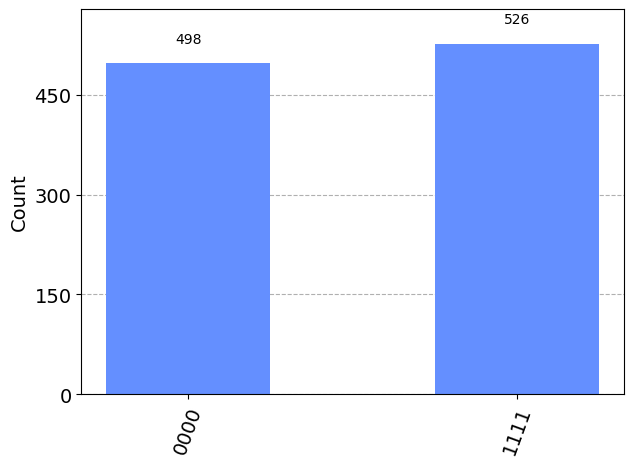

In [42]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

## Noise example 1: Basic bit-flip error noise model

Let's consider a simple toy noise model example common in quantum information theory research:

*   When applying a single-qubit gate, flip the state of the qubit with probability `p_gate1`.

*   When applying a two-qubit gate, apply single-qubit errors to each qubit.

*   When resetting a qubit, reset to 1 instead of 0 with probability `p_reset`.

*   When measuring a qubit, flip the state of the qubit with probability `p_meas`.

In [43]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u2', 'measure', 'cx', 'u1', 'reset', 'u3']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Execute the noisy simulation

/opt/homebrew/Caskroom/miniforge/base/envs/quarmen2/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/quarmen2/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


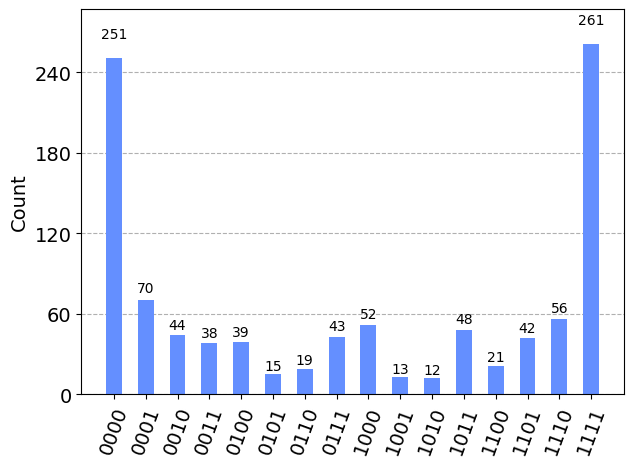

In [44]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)


# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
circ_tnoise = passmanager.run(circ)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

### Real HW simulation
To simulate with noise, specify a system (quantum hardware) and submit it to Aer.  Aer builds a noise model based on the calibration data from that system, and instantiates an Aer backend with that model.  If you prefer, you can [build a noise model](/verify/building_noise_models).

In [45]:
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

# Bell Circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

service = QiskitRuntimeService()

# Specify a system to use for the noise model
real_backend = service.backend("ibm_brisbane")
aer = AerSimulator.from_backend(real_backend)

# Run the sampler job locally using AerSimulator.
pm = generate_preset_pass_manager(backend=aer, optimization_level=1)
isa_qc = pm.run(qc)
sampler = Sampler(backend=aer)
result = sampler.run([isa_qc]).result()

RequestsApiError: 'HTTPSConnectionPool(host=\'auth.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/version (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x2a8d77a90>: Failed to resolve \'auth.quantum-computing.ibm.com\' ([Errno 8] nodename nor servname provided, or not known)"))'

### General Backend
 `GenericBackendV2`, to the `qiskit.providers.fake_provider module`. This class is configurable, and builds a `BackendV2` backend instance that can be run locally (in the spirit of fake backends). Users can configure the number of qubits, basis gates, coupling map, ability to run dynamic circuits (control flow instructions), instruction calibrations and measurement timestep of the backend without having to deal with manual target construction. Qubit and gate properties (duration, error) are generated by randomly sampling from default ranges. The seed for this random generation can be fixed to ensure the reproducibility of the backend output. It’s important to note that this backend only supports gates in the standard library. If you need a more flexible backend, there is always the option to directly instantiate a `Target` object to use for transpilation.

Here, in addition, we visualize a scheduled circuit program. You can call this function with set of control arguments. Most of appearance of the output image can be controlled by the stylesheet.
#### Drawing with the stylesheet suited for program debugging.

In [ ]:
from qiskit import QuantumCircuit, transpile, schedule
from qiskit.visualization.timeline import draw, IQXDebugging
from qiskit.providers.fake_provider import GenericBackendV2
 
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
 
qc = transpile(qc, GenericBackendV2(5), scheduling_method='alap', layout_method='trivial')
draw(qc, style=IQXDebugging())

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import GenericBackendV2
 
# Create a simple circuit
circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(0,2)
circuit.measure_all()
circuit.draw('mpl')

In [ ]:
from qiskit.visualization.timeline import draw, IQXDebugging

# Define backend with 3 qubits
backend = GenericBackendV2(num_qubits=3)
 
# Transpile and run
transpiled_circuit = transpile(circuit, backend)

result = backend.run(transpiled_circuit).result()

In [ ]:
result

### Example 2

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.providers.fake_provider import GenericBackendV2
 
# Create a circuit with classical control
creg = ClassicalRegister(19)
qc = QuantumCircuit(25)
qc.add_register(creg)
qc.h(0)
for i in range(18):
    qc.cx(0, i + 1)
for i in range(18):
    qc.measure(i, creg[i])
with qc.if_test((creg, 0)):
    qc.ecr(20, 21)
 
# Define backend with custom basis gates and control flow instructions
backend = GenericBackendV2(
    num_qubits=25,
    basis_gates=["ecr", "id", "rz", "sx", "x"],
    control_flow=True,
  )
 
#Transpile
transpiled_qc = transpile(qc, backend)

In [ ]:
transpiled_qc.draw()

Before you can access IBM Quantum services, you need an IBM Quantum account. You can sign up for an account at https://quantum-computing.ibm.com/.

Once you have an account, you can grab your API token

## Overview of Quantum States

State-vector notation  is convenient when dealing with states that can always be expressed as a linear combination of basis states, each with an associated probability amplitude. The definition of the state of our qubits cannot always be written down as linear combinations in a given basis, sometimes it must be expressed in terms of ensembles (statistical mixtures) of multiple states (noise), each with an associated probability of occurrence. The adopted formulation is the `density matrix`. 
In the following we will review this formulation for ***pure state***, **mixed state** and we introduce the concept of **state purity** and ***partial trace***.

#### Pure State
Pure states are those for which we can precisely define their quantum state at every point in time and the measurement outcome will be probabilistic with no uncertainty on what this quantum state will be.
For example, if we initialize the single qubit $|q \rangle $ in state $ | 0 \rangle $, and apply a Hadamard gate, we know our final state will be:

$$ 
| q \rangle = \frac{1}{\sqrt{2}} \left( | 0 \rangle  + | 1 \rangle  \right) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 1 \end{bmatrix} = | + \rangle 
$$
In general, we know that in the conventional state vector notation, an $n$-qubit pure state can be expressed as:

$$ | \psi \rangle = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_{N-1} \end{bmatrix}, $$

where $ N = 2^{n} $. An alternative way to express this pure quantum state is in the form of a matrix. This can be done by using the density operator representation, which is defined as:

$$ \rho \equiv  | \psi \rangle \langle \psi | $$

Here, the term $| \psi \rangle \langle \psi | $ represents the [outer product](../ch-gates/proving-universality.ipynb#outer) of the state $ \psi $ with itself:


$$ 
\begin{aligned}
& \rho = \begin{bmatrix} \alpha_0 \\ \alpha_1 \\ \vdots \\ \alpha_N \end{bmatrix} \begin{bmatrix} \alpha_0^* & \alpha_1^* & \dots & \alpha_N^* \end{bmatrix} 
\\
\\
& \rho = \begin{bmatrix} |\alpha_0|^2 & \alpha_0 \alpha_1^* & \dots & \alpha_0 \alpha_N^* \\ \alpha_1 \alpha_0^* & |\alpha_1|^2 & \dots & \alpha_1 \alpha_N^* \\ \vdots & \vdots & \ddots & \vdots \\ \alpha_N \alpha_0^* & \alpha_N \alpha_1^* & \dots & |\alpha_N|^2 \end{bmatrix}
\end{aligned}
$$


Let's consider, for example, the following two-qubit, maximally-entangled pure state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0 0 \rangle + | 1 1 \rangle \right ) = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} 
$$


The density matrix representation for this state is then given by:

$$ 
\begin{aligned}
& \rho_{AB}  = | \psi_{AB} \rangle \langle \psi_{AB} |
\\
\\
& \rho_{AB} = \left ( \frac{1}{\sqrt{2}} \begin{bmatrix} 1 \\ 0 \\ 0 \\ 1 \end{bmatrix} \right ) \left ( \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 0 & 0 & 1 \end{bmatrix} \right )
\\
\\
& \rho_{AB} = \frac{1}{2} \begin{bmatrix} 1 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 1 \\ \end{bmatrix}
\end{aligned}
$$


In Qiskit, we can use the ``quantum_info`` module to represent quantum states either in state vector notation, or in the density matrix representation. For convenience, we will import this module as ``qi``:

In [46]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

Let's once again consider the entangled pure state $| \psi_{AB} \rangle $. We can prepare this state by applying a Hadamard gate to the first qubit, and an CNOT between the first and second qubits:

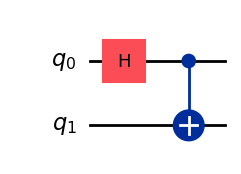

In [47]:
qc_AB = QuantumCircuit(2)
qc_AB.h(0)
qc_AB.cx(0,1)
qc_AB.draw('mpl')

To obtain the state constructed by our ``QuantumCircuit`` in state vector notation, we can make use of the ``Statevector.from_instruction()`` class method from the ``quantum_info`` module as follows:

In [48]:
psi_AB = qi.Statevector.from_instruction(qc_AB)
psi_AB.draw('latex', prefix='|\\psi_{AB}\\rangle = ')

<IPython.core.display.Latex object>

Similarly, we can use the ``DensityMatrix.from_instruction()`` class method to obtain density matrix representation for this same state:

In [49]:
rho_AB = qi.DensityMatrix.from_instruction(qc_AB)
rho_AB.draw('latex', prefix='\\rho_{AB} = ')

<IPython.core.display.Latex object>

As expected, the result matches our calculation. We can also visualize the density matrix using a cityscape plot of the state:

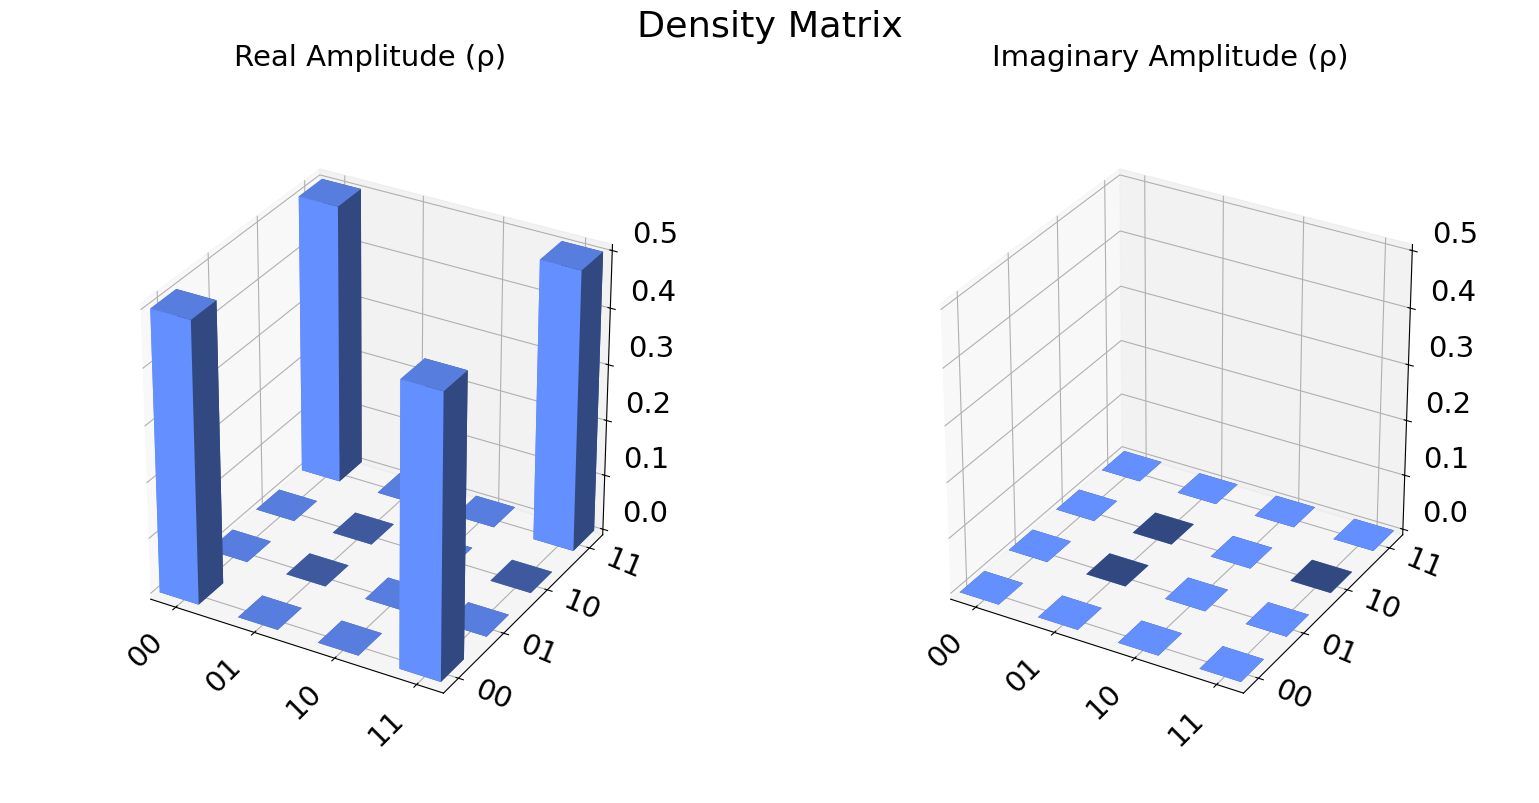

In [50]:
from qiskit.visualization import plot_state_city
plot_state_city(rho_AB.data, title='Density Matrix')

### 1. Exercises  <a id="ex1"></a>
Find the corresponding density matrix for the following pure states. Use Qiskit to prepare the states, and verify your results using the ``quantum_info`` module:
   
1.	$ \frac{1}{2}\left ( |0 0 \rangle + |0 1 \rangle + |1 0 \rangle + |1 1 \rangle \right ) $       



Now, all we have done so far is show a different way to represent quantum states, but there is no apparent advantage in doing so. To understand why the density matrix representation is beneficial, we need to learn about the concept of mixed states.

## 2. Mixed States <a id="mixed"></a>

Mixed states are those that consist of statistical ensembles of different quantum states.

Consider, once again, the two-qubit entangled state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0_A 0_B \rangle + | 1_A 1_B \rangle \right ) $$

Here we have explicitly used the subscripts $A$ and $B$ to label the qubits associated with registers $q_1$ and $q_0$, respectively. Now, let's assume that right after preparing our state $| \psi_{AB} \rangle $ we perform a measurement on register $q_1$.


We know that after a measurement, $\psi_B$ will be in state $| 0_B \rangle $ with probability $1/2$, or in state $| 1_B \rangle $ with probability $1/2$; however, $\psi_B$ is **not** in a linear superposition of $| 0_B \rangle $ and $| 1_B \rangle $. In other words, $\psi_B$ **cannot** be expressed as a state vector of the form $1/\sqrt{2} \left (|0_B \rangle + | 1_B \rangle \right)$. Instead, we have to use a different notation to write down that $\psi_B$ is rather an ensemble (not a quantum superposition) of the states $| 0_B \rangle $ and $| 1_B \rangle $, and whose outcome depends on what we measure on register $q_1$. 

We then call $\psi_B$ a mixed state, which can be represented as an ensemble of states:

$$
\left \{| \psi_{B_0} \rangle , | \psi_{B_1} \rangle \right \} = \left \{ | 0_B \rangle , | 1_B \rangle \right \},
$$ 

each with an associated probability of occurrence:

$$ \left \{ p_0, p_1 \right \} = \left \{ 1/2, 1/2 \right \} $$

Although this way of expressing $\psi_B$ (or any general mixed state) is perfectly valid, it turns out to be somewhat inconvenient. Since a mixed state can consist of a myriad of pure states, it can be difficult to track how the whole ensemble evolves when, for example, gates are applied to it. It is here that we turn to the density matrix representation.

A mixed state, consisting of several possible outcome pure states $|\psi_j \rangle$ , each with probability of occurrence $p_j$, is defined as a density matrix of the form:

$$ \rho \equiv \sum_{j} p_j |\psi_j \rangle \langle \psi_j | $$

It is easy to see that this general definition of the density matrix also holds for pure states, for which we will only have one $ |\psi_j \rangle $ term with $p_j = 1$.

### State Purity <a id="trace_sqr"></a>

A very useful property of the density matrix is that when taking the trace $\text{Tr}$ of its square $\rho^{2}$, we obtain a scalar value $\gamma$ that is good measure of the purity of the state the matrix represents. For normalized states, this value is always less than or equal to 1, with the equality occurring for the case of a pure state:

$$ \gamma \equiv \text{Tr}(\rho^{2}) \leq 1 $$

$$ \gamma \equiv \text{Tr}(\rho^{2}) = 1 \; \text{if pure} $$

In Qiskit, we can easily extract the purity of a density matrix by using the `purity()` class method. For example, for the pure state $| + \rangle$, we should expect to see a purity of 1:

In [51]:
import numpy as np
rho_p = qi.DensityMatrix.from_label('+')
display(rho_p.draw('latex', prefix='\\rho_p = '))
gamma_p = rho_p.purity()
print("State purity: ", np.round(np.real(gamma_p),3))

<IPython.core.display.Latex object>

State purity:  1.0


And, for a mixed state, like $\rho_m = \frac{1}{2} | 0 \rangle \langle 0 | + \frac{1}{2} | 1 \rangle \langle 1 | $, we expect a purity of less than 1:

In [52]:
rho_m = 1/2*(qi.DensityMatrix.from_label('0') + qi.DensityMatrix.from_label('1'))
display(rho_m.draw('latex', prefix='\\rho_m = '))
gamma_m = rho_m.purity()
print("State purity: ", np.round(np.real(gamma_m),3))

<IPython.core.display.Latex object>

State purity:  0.5


***NB*** One of the drawbacks of representing the density matrices in terms of ensembles of basis states, is that their outcome is not unique. Understanding that the same density matrix can represent many different ensembles of quantum states is important to avoid drawing conclusions about a particular system simply based on its density matrix representation alone. 

### The Reduced Density Matrix
When working with the density matrix notation on composite systems, we can extract the state of each subsystem, even if they are entangled. This is done in the form of what is known as the reduced density matrix.

Consider a quantum system composed of subsystems $A$ and $B$, and fully described by the density matrix $\rho_{AB}$. The reduced density matrix of subsystem $A$ is then given by:

$$ \rho_{A} = \text{Tr}_B(\rho_{AB}), $$


Here, $\text{Tr}_B$ is an operation known as the partial trace, which is defined as: 

$$
\text{Tr}_B \left (| \xi_u \rangle \langle \xi_v | \otimes | \chi_u \rangle \langle \chi_v | \right ) \equiv | \xi_u \rangle \langle \xi_v | \text{ Tr} \left ( | \chi_u \rangle \langle \chi_v | \right )
$$

$| \xi_u \rangle $ and $| \xi_v \rangle $ are arbitrary states in the subspace of $A$, and $| \chi_u \rangle $ and $| \chi_v \rangle $ arbitrary states in the subspace of $B$. $\text{Tr}$ is the standard trace operation, which for two arbitrary states $\text{Tr} \left ( | \chi_u \rangle \langle \chi_v | \right ) = \langle \chi_v |\chi_u \rangle $. Similarly, we can calculate the reduced density matrix of subsystem $B$ using the partial trace over $A$.

As an example, let's reconsider the pure entangled state:

$$ | \psi_{AB} \rangle = \frac{1}{\sqrt{2}} \left ( | 0_A 0_B \rangle + | 1_A 1_B \rangle \right ) $$




This system is then composed of single-qubit subsystem $A$ with basis vectors $ \left \{ |\xi_1 \rangle, |\xi_2 \rangle \right \} = \{ | 0_A \rangle, | 1_A \rangle \}$, and single-qubit subsystem $B$ with basis vectors $ \left \{ |\chi_1 \rangle, |\chi_2 \rangle \right \} = \{ | 0_B \rangle, | 1_B \rangle \}$. We know that this system is not separable (i.e., $| \chi_{AB} \rangle \neq |\chi_{A}\rangle \otimes |\chi_{B}\rangle$); however, by using the reduced density matrix, we can find a full description for subsystems $A$ and $B$ as follows.

The density matrix of our state $| \psi_{AB} \rangle$ can be expressed in terms of outer products of the basis vectors as:

$$
\rho_{AB} = | \psi_{AB} \rangle \langle \psi_{AB} | =  \frac{1}{2} \left [ | 0_A 0_B \rangle \langle 0_A 0_B | + | 0_A 0_B \rangle \langle 1_A 1_B | + | 1_A 1_B \rangle \langle 0_A 0_B | + | 1_A 1_B \rangle \langle 1_A 1_B | \right ]
$$


Now, to calculate the reduced density matrix for, let's say, subsystem $B$, we have:

$$
\begin{aligned}
\rho_{B} & = \text{Tr}_A(\rho_{AB})
\\
\\
& = \frac{1}{2}\left [ \text{Tr}_A(| 0_A 0_B \rangle \langle 0_A 0_B |) + \text{Tr}_A(| 0_A 0_B \rangle \langle 1_A 1_B |) + \text{Tr}_A(| 1_A 1_B \rangle \langle 0_A 0_B |) + \text{Tr}_A(| 1_A 1_B \rangle \langle 1_A 1_B |) \right ]
\\
\\
& = \frac{1}{2}\left [ \text{Tr}(| 0_A \rangle \langle 0_A |)| 0_B \rangle \langle 0_B | + \text{Tr}(| 0_A \rangle \langle 1_A |)| 0_B \rangle \langle 1_B | + \text{Tr}(| 1_A \rangle \langle 0_A |) | 1_B \rangle \langle 0_B | + \text{Tr}(| 1_A \rangle \langle 1_A |) | 1_B \rangle \langle 1_B | \right ]
\\
\\
& = \frac{1}{2}\left [ \langle 0_A | 0_A \rangle | 0_B \rangle \langle 0_B | + \langle 1_A | 0_A \rangle | 0_B \rangle \langle 1_B | + \langle 0_A | 1_A \rangle | 1_B \rangle \langle 0_B | + \langle 1_A | 1_A \rangle | 1_B \rangle \langle 1_B | \right ]
\\
\\
& = \frac{1}{2}\left [ | 0_B \rangle \langle 0_B | + | 1_B \rangle \langle 1_B | \right ]
\\
\\
&= \frac{1}{2} \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} 
\end{aligned}
$$



At first glance, this result might seem rather strange. We started with the pure entangled state $|\psi_{AB} \rangle $, and  calculated that the state of one of its parts (subsystem $B$) is the mixed state $\rho_{B}$. However, going back to the first example given above, we see that the result from calculating the reduced density matrix for $B$ is equivalent to the representation we obtained for $\psi_B$, when measurements were taken over qubit $A$. We can then conclude that the reduced density matrix $\rho_{B}$ is a way to describe the statistical outcomes of subsystem $B$, when the measurement outcomes of subsystem $A$ are averaged out. This is in fact what ”tracing out” subsystem $A$ means.

It is worth mentioning that so far we have described the concept of partial trace for a bipartite (two-part) system, but this can be generalized for multi-part systems.

In Qiskit, we can easily obtain the reduced density matrix of a system by using the ``partial_trace()`` function and passing the density matrix of the composite system, and a list with the subsystems to trace over:



In [53]:
rho_B = qi.partial_trace(rho_AB,[0])
rho_A = qi.partial_trace(rho_AB,[1])

display(rho_B.draw('latex', prefix=" \\rho_{B} = "),
        rho_A.draw('latex', prefix=" \\rho_{A} = "))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [54]:
I = qi.mutual_information(rho_m, base=2)
I

QiskitError: 'Input must be a bipartite quantum state.'

In [55]:
I = qi.mutual_information(psi_AB, base=2)
I

2.0

see here for all methods https://docs.quantum.ibm.com/api/qiskit/0.43/qiskit.quantum_info.mutual_information

### Exercises  <a id="ex4"></a>
Calculate the reduced density matrices for following:

The mixed state: $ \rho_{mr} = \frac{1}{4} | \Phi^+ \rangle \langle \Phi^+ | + \frac{3}{4} | \Phi^- \rangle \langle \Phi^- |$, where $| \Phi^+ \rangle$ and $| \Phi^- \rangle$ are the Bell states:

$| \Phi^+ \rangle = \frac{1}{\sqrt{2}} \left( |00 \rangle + |11 \rangle \right ) $

$| \Phi^- \rangle = \frac{1}{\sqrt{2}} \left( |00 \rangle - |11 \rangle \right ) $
    
    
    and for the following quantum circuit

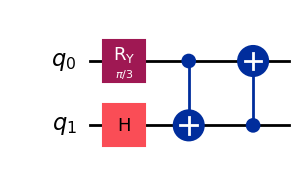

In [56]:
qc_CD = QuantumCircuit(2)
qc_CD.ry(np.pi/3,0)
qc_CD.h(1)
qc_CD.cx(0,1)
qc_CD.cx(1,0)
qc_CD.draw("mpl")